# **Text Mining Project**

## **Group Registration**

|      |     Student Name     |     Student ID     |
|---   |         ---          |           ---          |
| 1    |      Filipe Dias        |       r20181050        |
| 2    |      Inês Santos       |       r20191184         |
| 3    |      Manuel Marreiros       |       r20191223        |

## **Imports and Data Integration**

In [ ]:
pip install langdetect

In [ ]:
pip install fasttext

In [ ]:
pip install sentence_transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Preprocessing and Feature Extraction
from bs4 import BeautifulSoup #remove html tags
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import gensim.downloader as api

# NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import fasttext
from sentence_transformers import SentenceTransformer

# Classifiers
from sklearn.model_selection import GridSearchCV #for hyperparameter optimization
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from tensorflow.keras import Input, layers
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Masking

# Evaluation metrics
from keras import backend as K
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
airbnb_df_train = pd.read_excel('/content/drive/MyDrive/Faculdade Cursos Linkedin/Text MIning /train.xlsx')
airbnb_df_test = pd.read_excel('/content/drive/MyDrive/Faculdade Cursos Linkedin/Text MIning /test.xlsx')

In [ ]:
airbnb_df_train = airbnb_df_train.set_index('index')
airbnb_df_test = airbnb_df_test.set_index('index')

In [ ]:
airbnb_df_train.head()

,description,host_about,unlisted
index,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [ ]:
train_reviews = pd.read_excel('/content/drive/MyDrive/Faculdade Cursos Linkedin/Text MIning /train_reviews.xlsx')
test_reviews = pd.read_excel('/content/drive/MyDrive/Faculdade Cursos Linkedin/Text MIning /test_reviews.xlsx')

In [ ]:
train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


## **1. Data Exploration**

Let's start by seeing how many listed and unlisted rooms we have.

In [ ]:
airbnb_df_train['unlisted'].value_counts()

0    9033
1    3463
Name: unlisted, dtype: int64

We will now look into the text fields (independent variables) to get a better grasp of what elements they contain.

In [ ]:
airbnb_df_train['description'][50]

'Show up and start living from day one in Lisbon with this cozy two-bedroom Blueground apartment. You’ll love coming home to this thoughtfully furnished, beautifully designed, and fully-equipped Baixa home. (ID #LIS48)<br /><br /><b>The space</b><br />Gorgeous furniture, fully-equipped kitchen, smart TV, and a premium wireless speaker are just a few of the amenities you’ll find inside this two-bedroom apartment. Ideally located in Lisbon, you’ll find a lot to love outside as well. When you’re ready to relax, you’ll be happy to discover every Blueground bedroom comes with superior quality mattresses, luxury linens, and cozy towels. We handle everything so you can simply show up and start living. <br /><br />Amenities<br /><br />Building amenities unique to this two-bedroom include an on-site:<br /><br />  - Elevator<br /><br />Please check the house rules prior to booking as other fees and limitations may apply.<br /><br /><b>Other things to note</b><br />This Blueground apartment has f

In [ ]:
airbnb_df_train['description'].isna().sum()

0

We can see that there are no rows missing a description.

In [ ]:
airbnb_df_train['host_about'][50]

'We’re Blueground, a global proptech company with several thousand move-in-ready apartments in a growing number of major cities around the world. With flexible terms and homes in vibrant, centrally based neighborhoods, you’ll feel at home and free to roam for as long as you want — a month, a year, or longer. \n\nEach apartment is thoughtfully designed with exclusive furnishings, fully equipped kitchens, and incredible amenities – making every day a five-star experience. From day one, you’ll enjoy high-speed Wi-Fi, premium linens, and smart home entertainment. Plus, access to pools, gyms, and outdoor spaces in select buildings.\n\nWhy stress over your apartment? We provide a hassle-free alternative — a consistent, quality guest experience that starts even before you arrive. Because we let you book our most up-to-date apartment listings online, confirm with a click, pay securely, and check in easily. \n\nDuring your stay\nUpon arrival, you’ll either be greeted personally by a Blueground 

In [ ]:
airbnb_df_train['host_about'].isna().sum()

0

In [ ]:
airbnb_df_train.info()

In [ ]:
train_reviews['comments'][50]

In [ ]:
train_reviews['comments'].isna().sum()

In [ ]:
train_reviews.info()

### **1.1 Word Count**

Let's start by doing some basic exploration of the airbnb_df_train dataframe.

In [ ]:
# Fetch wordcount for each abstract
airbnb_df_train['word_count']  = airbnb_df_train['description'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['description','word_count']].head()

,description,word_count
index,,
1,"This is a shared mixed room in our hostel, wit...",127
2,"O meu espaço fica perto de Parque Eduardo VII,...",23
3,Trafaria’s House is a cozy and familiar villa ...,170
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",47
5,Joli appartement en bordure de mer.<br /> 2 m...,101


In [ ]:
airbnb_df_train.word_count.describe()

count    12496.000000
mean       132.663572
std         48.494104
min          3.000000
25%         99.000000
50%        157.000000
75%        167.000000
max        210.000000
Name: word_count, dtype: float64

<AxesSubplot:>

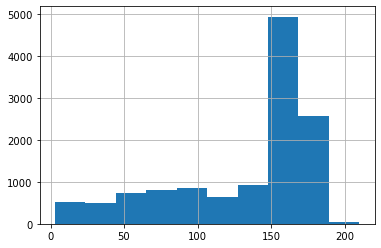

In [ ]:
airbnb_df_train['word_count'].hist()

From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest description has 210 words
- The smallest description has only 3 words
- On average, descriptions have around 132 words

In [ ]:
all_words = ' '.join(airbnb_df_train['description']).split()

In [ ]:
freq = pd.Series(all_words).value_counts()

In [ ]:
freq.sort_values(ascending=False)[0:10]

the      62717
and      54907
a        50700
/><br    34826
to       30520
of       30050
in       28007
with     27033
is       23957
de       13708
dtype: int64

As we can see, html tags are very present in our data. In fact, the '/><br' html tag appears in the 10 most frequent words. Because of that, we'll need to drop it, so that we can assess the actual 10 most frequent words in the airbnb descriptions. Here we are just dealing with the tags for this Series, a more thorough approach will be taken when preprocessing the actual dataset.

In [ ]:
freq = freq.drop('/><br')
freq = freq.drop('</b><br')
freq = freq.drop('space</b><br')
freq = freq.drop('number</b><br')

In [ ]:
freq.sort_values(ascending=False)[0:10]

the          62717
and          54907
a            50700
to           30520
of           30050
in           28007
with         27033
is           23957
de           13708
apartment    13608
dtype: int64

In [ ]:
freq.index[0:10]

Index(['the', 'and', 'a', 'to', 'of', 'in', 'with', 'is', 'de', 'apartment'], dtype='object')

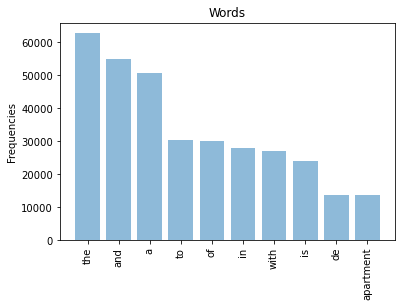

In [ ]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Create the word cloud object with frequency information
wordcloud = WordCloud(width=1200, height=800, background_color='white').generate_from_frequencies(freq)

# Display the word cloud using matplotlib
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
airbnb_df_train = airbnb_df_train.drop('word_count', axis=1)

Let's do the same for the other dataframe.

In [ ]:
# Fetch wordcount for each abstract
train_reviews['word_count']  = train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
train_reviews[['comments','word_count']].head()

,comments,word_count
0,this is a very cozy and comfortable house to s...,31
1,good < br / >,5
2,"my first hostel experience, and all i have to ...",344
3,das hostel war neu und deshalb funktionierte a...,120
4,"it was fine for a dorm, but i think for the pe...",27


In [ ]:
train_reviews.word_count.describe()

count    721402.000000
mean         47.993793
std          46.922807
min           1.000000
25%          18.000000
50%          36.000000
75%          63.000000
max        1064.000000
Name: word_count, dtype: float64

<Axes: >

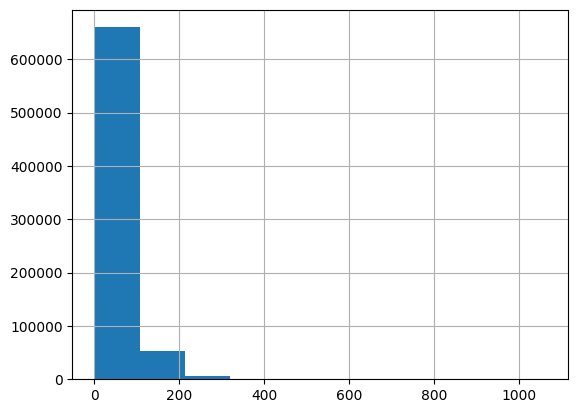

In [ ]:
train_reviews['word_count'].hist()

In [ ]:
all_words = ' '.join(train_reviews['comments'] ).split()

In [ ]:
freq_reviews = pd.Series(all_words).value_counts()

In [ ]:
freq_reviews.sort_values(ascending=False)[0:10]

In [ ]:
freq_reviews = freq_reviews.drop('/><br')
freq_reviews = freq_reviews.drop('</b><br')
freq_reviews = freq_reviews.drop('space</b><br')
freq_reviews = freq_reviews.drop('number</b><br')

In [ ]:
freq_reviews.index[0:10]

In [ ]:
x_labels = freq_reviews.index[0:10]
values = freq_reviews[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Create the word cloud object with frequency information
wordcloud = WordCloud(width=1200, height=800, background_color='white').generate_from_frequencies(freq_reviews)

# Display the word cloud using matplotlib
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
train_reviews = train_reviews.drop('word_count', axis=1)

## **2. Data Preprocessing**

Let's start by fixing the data type of the comments column of the reviews dataframes.

In [ ]:
train_reviews['comments'] = train_reviews['comments'].astype(str)
test_reviews['comments'] = test_reviews['comments'].astype(str)

### **2.1. Removing HTML tags**

As we have seen before, our documents were full of html tags. Therefore, we must get rid of them before doing any additional preprocessing.

In [ ]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator=' ')
    return clean_text

airbnb_df_train['description'] = airbnb_df_train['description'].apply(remove_html_tags)
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(remove_html_tags)
train_reviews['comments'] = train_reviews['comments'].apply(remove_html_tags)

<ipython-input-7-8d51daeddf4f>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


### **2.2. Regular Expressions**

In [ ]:
for i, row in airbnb_df_train.iterrows():
    airbnb_df_train.at[i, 'description'] = re.sub(r'(?i)\b(?:License number|Alojamento Local Registro):?(?:</b><br />)?\s*(\S+)', '#LICENSENUMBER', row['description'])

### **2.3. Additional Cleaning**

In [ ]:
stop = set(stopwords.words('english'))

In [ ]:
stemmer = SnowballStemmer('english')

In [ ]:
lemma = WordNetLemmatizer()

In [ ]:
def clean(text_list, lemmatize, stemming):

    updates = []

    for j in tqdm(text_list):

        text = j

        #LOWERCASE TEXT
        text = text.lower()

        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])

        #Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        #Stemming
        if stemming:
            text = " ".join(stemmer.stem(word) for word in text.split())

        updates.append(text)

    return updates

In [ ]:
updates_description = clean(airbnb_df_train['description'], lemmatize = True, stemming = False)

100%|██████████| 12496/12496 [00:05<00:00, 2263.72it/s]


In [ ]:
updates_host = clean(airbnb_df_train['host_about'], lemmatize = True, stemming = False)

100%|██████████| 12496/12496 [00:02<00:00, 5044.97it/s]


***Note: the cell below (and some others) is commented because we ran these steps and saved the final dataset to a dataframe in order to save time and avoid having to run everything all the time. Since the excel files were too large to include in the moodle submission, running the commented cells might be necessary for the good functioning of the code. ***

In [ ]:
#updates_comments = clean(train_reviews['comments'], lemmatize = True, stemming = False)

Example of a description before going through the cleaning pipeline:

In [ ]:
airbnb_df_train['description'][50]

'Show up and start living from day one in Lisbon with this cozy two-bedroom Blueground apartment. You’ll love coming home to this thoughtfully furnished, beautifully designed, and fully-equipped Baixa home. (ID #LIS48) The space Gorgeous furniture, fully-equipped kitchen, smart TV, and a premium wireless speaker are just a few of the amenities you’ll find inside this two-bedroom apartment. Ideally located in Lisbon, you’ll find a lot to love outside as well. When you’re ready to relax, you’ll be happy to discover every Blueground bedroom comes with superior quality mattresses, luxury linens, and cozy towels. We handle everything so you can simply show up and start living.  Amenities Building amenities unique to this two-bedroom include an on-site:   - Elevator Please check the house rules prior to booking as other fees and limitations may apply. Other things to note This Blueground apartment has fl'

In [ ]:
def update_df(dataframe, column_name, list_updated):
    list_updated.insert(0, None)  # adding an empty object to the first position of the list, so that the ids match with the dataframe
    dataframe.update(pd.DataFrame({column_name: list_updated}))

In [ ]:
update_df(airbnb_df_train, 'description', updates_description)
update_df(airbnb_df_train, 'host_about', updates_host)
#update_df(train_reviews, 'comments', updates_comments)

Same description as before after being cleaned:

In [ ]:
airbnb_df_train['description'][50]

'show start living day one lisbon cozy two bedroom blueground apartment love coming home thoughtfully furnished beautifully designed fully equipped baixa home id li space gorgeous furniture fully equipped kitchen smart tv premium wireless speaker amenity find inside two bedroom apartment ideally located lisbon find lot love outside well ready relax happy discover every blueground bedroom come superior quality mattress luxury linen cozy towel handle everything simply show start living amenity building amenity unique two bedroom include site elevator please check house rule prior booking fee limitation may apply thing note blueground apartment fl'

### **2.4. Filtering out non-English comments**

In [ ]:
# Initializing the language detector
detect_lang = lambda x: detect(x) if x.strip() != "" else "unknown"

In [ ]:
train_reviews['language'] = train_reviews['comments'].apply(detect_lang)

In [ ]:
train_reviews = train_reviews[train_reviews['language'] == 'en']

In [ ]:
train_reviews.to_excel('english_comments.xlsx', index=False)

In [ ]:
!cp english_comments.xlsx /content/drive/MyDrive

At this point, train reviews is already filtered to only include english comments.

In [ ]:
train_reviews = pd.read_excel('/content/drive/MyDrive/Faculdade Cursos Linkedin/Text MIning /english_comments.xlsx')

We will now append these reviews to the dataframe containing the columns description and host_about.

In [ ]:
grouped_df = train_reviews.groupby('index')['comments'].agg(lambda x: ' '.join(x)).reset_index()

The "comments" column above has all the reviews pee AirBnB in 1 cell. Let's now add it to the train dataset.

In [ ]:
# Perform a left join on 'airbnb_df_train' using the index column
merged_df = airbnb_df_train.merge(grouped_df, left_index=True, right_on='index', how='left')

In [ ]:
# Drop the redundant index column
merged_df.drop('index', axis=1, inplace=True)

In [ ]:
merged_df.reset_index(drop=True, inplace=True)
merged_df.index += 1

In [ ]:
# Replace NaN values in 'comments' column with an empty string
merged_df['comments'].fillna('', inplace=True)

In [ ]:
airbnb_df_train = merged_df

### **2.5. Spliting**

We will now split the dataset into two sets: X_train and X_val (representing the features) and y_train and y_val (representing the target variable). The features used for the split are 'description', 'host_about', and 'word_count' columns from the airbnb_df_train dataframe. The target variable is 'unlisted'. The split is done with a test size of 0.2, meaning 20% of the data will be used for validation, and the remaining 80% will be used for training. The split is also stratified based on the 'unlisted' column to ensure a proportional representation of unlisted listings in both the train and validation sets.

In [ ]:
airbnb_df_train

,description,host_about,unlisted,comments
1,shared mixed room hostel shared bathroom locat...,alojamento local registro al,0,this is a very cozy and comfortable house to s...
2,meu espa fica perto de parque eduardo vii sald...,friendly host try always around need anything ...,1,
3,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,1,
4,apartamento charmoso chiado entre largo carmo ...,hello x portuguese love meet people around wor...,0,
5,joli appartement en bordure de mer min pied de...,nous somme une famille avec deux enfants de et...,0,fantastic place felt home really enjoyed stayi...
...,...,...,...,...
12492,cat bairro alto cozy apartment lisbon city cen...,travelling one favorite hobby already visited ...,0,happy find place communication catarina easy f...
12493,beautifully located heart lisbon historic cent...,founded travel enthusiast like bnbird want con...,0,nice place nice location easy communication lo...
12494,enjoy eakfast sleek kitchen freestanding knott...,portugal love dance travel x pleasure welcome ...,0,location great lovely stay lisbon apartment gr...
12495,terra da eira uma casa de campo rodeada de rvo...,somos uma familia de gostamos de viajar e de r...,1,


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    airbnb_df_train[['description', 'host_about', 'comments']],
    airbnb_df_train['unlisted'],
    test_size=0.2,
    random_state=0,
    stratify=airbnb_df_train['unlisted']
)

### **2.5. Resampling**

Since the classes are not balanced (there are much more objects of class 0), we'll use resampling.

In [ ]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=1)
X_train, y_train = ros.fit_resample(X_train, y_train)
np.bincount(y_train)

array([7226, 7226])

## **3. Feature Engineering**

Since we have multiple columns with textual data, we need to flatten them into one array.

In [ ]:
text_columns = ['description', 'host_about', 'comments']

data_text_train = X_train[text_columns]
data_text_val = X_val[text_columns]

flattened_text_train = np.array([np.nan if pd.isnull(row).all() else ' '.join(row.dropna().astype(str)) for _ , row in data_text_train.iterrows()])
flattened_text_val = np.array([np.nan if pd.isnull(row).all() else ' '.join(row.dropna().astype(str)) for _ , row in data_text_val.iterrows()])

### **3.1. Bag of words**

In [ ]:
bow = CountVectorizer(binary=True)

flattened_text_train = np.array([np.nan if pd.isnull(row).all() else ' '.join(row.dropna().astype(str)) for _ , row in data_text_train.iterrows()])

X_train_bow = bow.fit_transform(flattened_text_train)
X_val_bow = bow.transform(flattened_text_val)

In [ ]:
df_bow = pd.DataFrame(X_train_bow[0].T.todense(), index=bow.get_feature_names_out(), columns=["Bag-of-words"])
df_bow = df_bow.sort_values('Bag-of-words', ascending=False)
print (df_bow.head(25))

            Bag-of-words
chair                  1
cleaned                1
full                   1
place                  1
stand                  1
located                1
though                 1
unkind                 1
eathtaking             1
shampoo                1
placed                 1
son                    1
especially             1
living                 1
eating                 1
leave                  1
fully                  1
refund                 1
leaving                1
drying                 1
basement               1
another                1
teenage                1
equipped               1
finally                1


In [ ]:
print("Bow train feature matrix shape:", X_train_bow.shape)
print("Bow validation feature matrix shape:", X_val_bow.shape)

Bow train feature matrix shape: (14452, 65312)
Bow validation feature matrix shape: (2500, 65312)


#### **3.1.1. Checking N-Grams with Bag of words**

In [ ]:
def get_top_n_grams(corpus, top_k, n):

    bow = CountVectorizer(binary=True, ngram_range=(n, n)).fit(corpus)

    bag_of_words = bow.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)

    words_freq = []
    for word, idx in bow.vocabulary_.items():
        words_freq.append((word, sum_words[0, idx]))

    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_df = pd.DataFrame(words_freq[:top_k])
    top_df.columns = ["Ngram", "Freq"]

    return top_df


def plot_frequencies(top_df):

    x_labels = top_df["Ngram"][:30]
    y_pos = np.arange(len(x_labels))
    values = top_df["Freq"][:30]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, x_labels)
    plt.ylabel('Frequencies')
    plt.title('Words')
    plt.xticks(rotation=90)
    plt.show()

Let's check the most frequent bi-grams in the description column:

In [ ]:
top_df = get_top_n_grams(updates_description[1:], top_k=20, n=2)
top_df.head(10)

,Ngram,Freq
0,living room,3911
1,guest access,3640
2,fully equipped,2840
3,thing note,2593
4,double bed,2192
5,equipped kitchen,2058
6,apartment located,1795
7,wi fi,1539
8,walking distance,1409
9,space apartment,1392


Most frequent bigrams to describe Lisbon AirBnBs

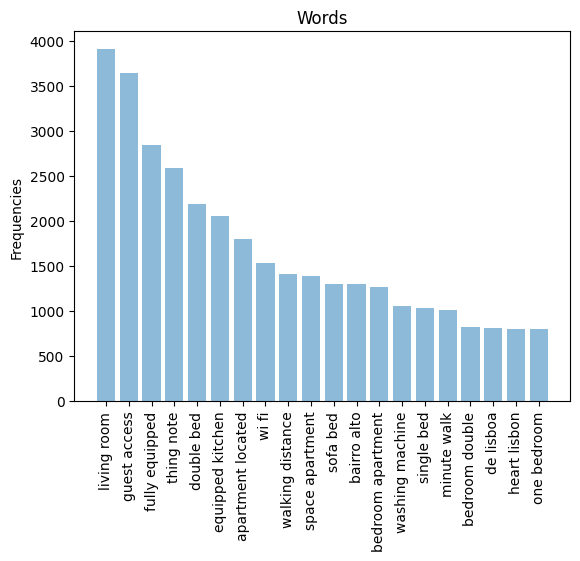

In [ ]:
plot_frequencies(top_df)

And now the tri-grams:

Most frequent trigrams to describe Lisbon AirBnBs

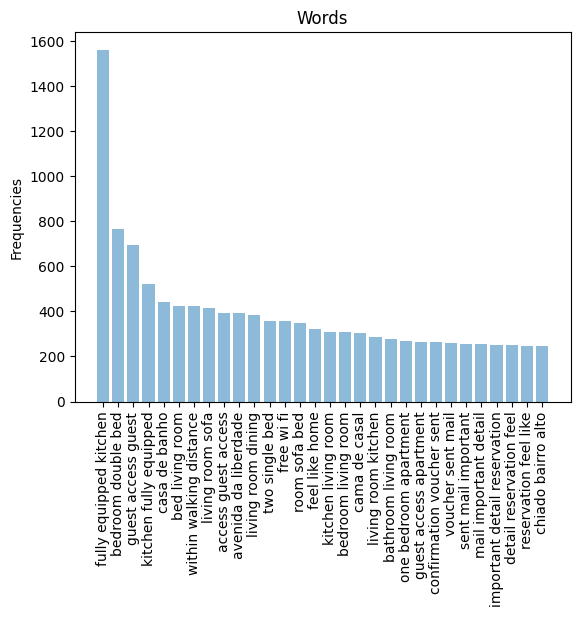

In [ ]:
top_df = get_top_n_grams(updates_description[1:], top_k=40, n=3)
plot_frequencies(top_df)

### **3.2. TF-IDF**

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1, 3))
X_train_Tfidf = vectorizer.fit_transform(flattened_text_train)
X_val_Tfidf = vectorizer.transform(flattened_text_val)

In [ ]:
df_vectorizer = pd.DataFrame(X_train_Tfidf[0].T.todense(), index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df_vectorizer = df_vectorizer.sort_values('TF-IDF', ascending=False)
print (df_vectorizer.head(25))

                                    TF-IDF
room                              0.082419
sleep choice                      0.079822
came open door                    0.073803
came open                         0.069587
stacked                           0.059828
tomorrow                          0.057890
dirty                             0.048428
apartment                         0.046028
sleep choice cannot               0.042921
utterly thrived apartment         0.042921
isabel apartment notwithstanding  0.042921
privacy one point                 0.042921
sleep choice care                 0.042921
cannot talk refund                0.042921
utterly thrived                   0.042921
stacked shower door               0.042921
sleeping street tomorrow          0.042921
fed start stressful               0.042921
stacked shower                    0.042921
fed start                         0.042921
whole check end                   0.042921
literally want end                0.042921
dirty laund

In [ ]:
print("TF-IDF train feature matrix shape:", X_train_Tfidf.shape)
print("TF-IDF validation feature matrix shape:", X_val_Tfidf.shape)

TF-IDF train feature matrix shape: (14452, 7952566)
TF-IDF validation feature matrix shape: (2500, 7952566)


### **3.3. GloVe**

In [ ]:
glove_model = api.load('glove-wiki-gigaword-100')  # Load pre-trained GloVe word vectors

[=================================================-] 98.3% 125.9/128.1MB downloaded


In [ ]:
emb_size = 100

#function to get embeddings for each word based on w2v list
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in glove_model.index_to_key:
                doc_vectors.append(glove_model.word_vec(word))
        corpus_vec.append(doc_vectors)
    return corpus_vec

In [ ]:
X_train_glove = corpus2vec(flattened_text_train)

  0%|          | 0/14452 [00:00<?, ?it/s]<ipython-input-112-b5461077d47b>:11: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  doc_vectors.append(glove_model.word_vec(word))
100%|██████████| 14452/14452 [59:34<00:00,  4.04it/s]


In [ ]:
X_val_glove = corpus2vec(flattened_text_val)

  0%|          | 0/2500 [00:00<?, ?it/s]<ipython-input-112-b5461077d47b>:11: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  doc_vectors.append(glove_model.word_vec(word))
100%|██████████| 2500/2500 [10:34<00:00,  3.94it/s]


### **3.4. Multilingual Word Embeddings (MWE)**

Multilingual embeddings are representations of words or phrases that capture their semantic meaning in multiple languages. They enable us to perform natural language processing tasks across different languages using a shared embedding space.

Implementing multilingual embeddings typically involves using pre-trained models or libraries specifically designed for this purpose. The one we chose was **Sentence-BERT (SBERT)**, which is known for its speed and high-quality multilingual embeddings. The paper where this model was first proposed describes it as "a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT".

In [ ]:
# Load the multilingual embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# Generate multilingual embeddings
def get_embeddings(text):
    return embedding_model.encode([text])[0]

In [ ]:
# Create new DataFrames based on the structure of X_train and X_val
X_train_emb = pd.DataFrame(columns=X_train.columns)
X_val_emb = pd.DataFrame(columns=X_val.columns)

In [ ]:
# Fill the new DataFrames with the values resulting from the Multilingual Word Embeddings model
X_train_emb['description'] = X_train['description'].apply(get_embeddings)
X_train_emb['host_about'] = X_train['host_about'].apply(get_embeddings)
X_train_emb['comments'] = X_train['comments'].apply(get_embeddings)
X_val_emb['description'] = X_val['description'].apply(get_embeddings)
X_val_emb['host_about'] = X_val['host_about'].apply(get_embeddings)
X_val_emb['comments'] = X_val['comments'].apply(get_embeddings)

In [ ]:
X_train_emb_flat = np.array([np.concatenate(cell) for cell in X_train_emb.values])
X_val_emb_flat = np.array([np.concatenate(cell) for cell in X_val_emb.values])

In [ ]:
np.savetxt('X_train_emb_flat.csv', X_train_emb_flat, delimiter=',')
np.savetxt('X_val_emb_flat.csv', X_val_emb_flat, delimiter=',')

In [ ]:
!cp X_train_emb_flat.csv /content/drive/MyDrive
!cp X_val_emb_flat.csv /content/drive/MyDrive

In [ ]:
## To read the csv with the saved mwe features
#X_train_emb_flat = pd.read_csv('/content/drive/My Drive/X_train_emb_flat.csv', header=None)
#X_val_emb_flat = pd.read_csv('/content/drive/My Drive/X_val_emb_flat.csv', header=None)

## **4. Classification Models**

In [ ]:
def plot_cm(confusion_matrix : np.array,
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis.
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes

    Returns:
        - Plot of the Confusion Matrix
    """

    confusionmatrix = confusion_matrix
    class_names = classnames

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

In [ ]:
labels = {"Listed":0, "Unlisted":1}

### **4.1. Logistic Regression**

#### **4.1.1 Logistic Regression with BoW**

In [ ]:
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
lr_bow_y_pred = lr_bow.predict(X_val_bow)

In [ ]:

print(classification_report(y_val, lr_bow_y_pred, target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.84      0.83      0.84      1807
    Unlisted       0.58      0.59      0.59       693

    accuracy                           0.77      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.77      0.77      0.77      2500



<ipython-input-50-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


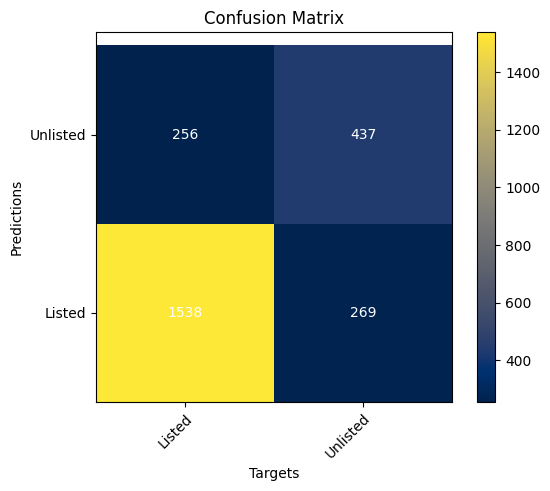

In [ ]:
plot_cm(confusion_matrix(y_val,lr_bow_y_pred), labels.keys())

#### **4.1.2 Logistic Regression with TF-IDF**

In [ ]:
lr_Tfidf = LogisticRegression()
lr_Tfidf.fit(X_train_Tfidf, y_train)

LogisticRegression()

In [ ]:
lr_Tfidf_y_pred = lr_Tfidf.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, lr_Tfidf_y_pred, target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.85      0.89      0.87      1807
    Unlisted       0.66      0.58      0.62       693

    accuracy                           0.80      2500
   macro avg       0.75      0.73      0.74      2500
weighted avg       0.80      0.80      0.80      2500



<ipython-input-27-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


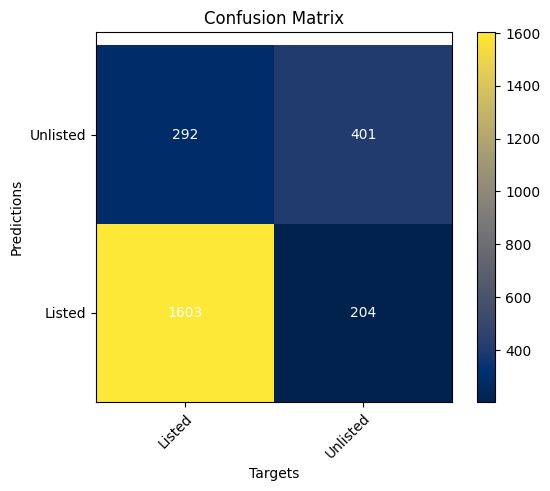

In [ ]:
plot_cm(confusion_matrix(y_val,lr_Tfidf_y_pred), labels.keys())

#### **4.1.3. Logistic Regression with MWE**

In [ ]:
lr_mwe = LogisticRegression()
lr_mwe.fit(X_train_emb_flat, y_train)

In [ ]:
lr_mwe_y_pred = lr_mwe.predict(X_val_emb_flat)

In [ ]:
labels = {"Listed":0, "Unlisted":1}
print(classification_report(y_val, lr_mwe_y_pred, target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.86      0.85      0.85      1807
    Unlisted       0.62      0.63      0.62       693

    accuracy                           0.79      2500
   macro avg       0.74      0.74      0.74      2500
weighted avg       0.79      0.79      0.79      2500



<ipython-input-50-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


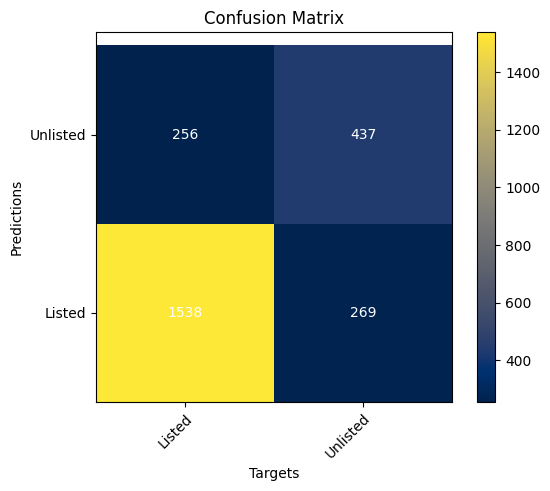

In [ ]:
plot_cm(confusion_matrix(y_val,lr_mwe_y_pred), labels.keys())

### **4.2 K-Nearest Neighbours (KNN)**

#### **4.2.1 KNN with BoW**

In [ ]:
knn_bow = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
knn_bow.fit(X_train_bow,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [ ]:
knn_bow_y_pred = knn_bow.predict(X_val_bow)

In [ ]:
print(classification_report(y_val, knn_bow_y_pred,target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.86      0.80      0.83      1807
    Unlisted       0.56      0.66      0.60       693

    accuracy                           0.76      2500
   macro avg       0.71      0.73      0.72      2500
weighted avg       0.78      0.76      0.77      2500



<ipython-input-27-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


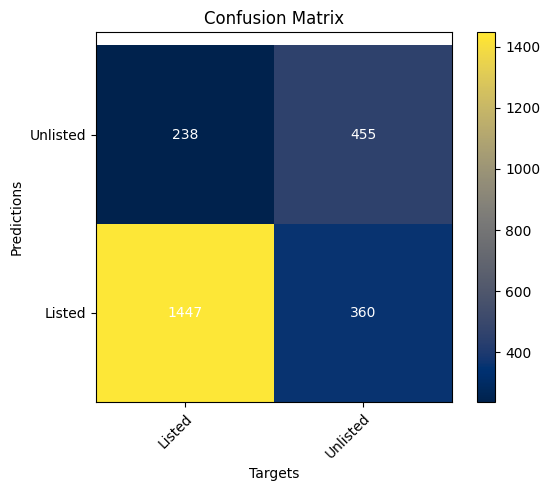

In [ ]:
plot_cm(confusion_matrix(y_val,knn_bow_y_pred), labels.keys())

#### **4.2.2 KNN with TF-IDF**

In [ ]:
knn_Tfidf = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
knn_Tfidf.fit(X_train_Tfidf,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [ ]:
knn_Tfidf_y_pred = knn_Tfidf.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, knn_Tfidf_y_pred,target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.86      0.71      0.78      1807
    Unlisted       0.48      0.70      0.57       693

    accuracy                           0.71      2500
   macro avg       0.67      0.70      0.67      2500
weighted avg       0.75      0.71      0.72      2500



<ipython-input-94-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


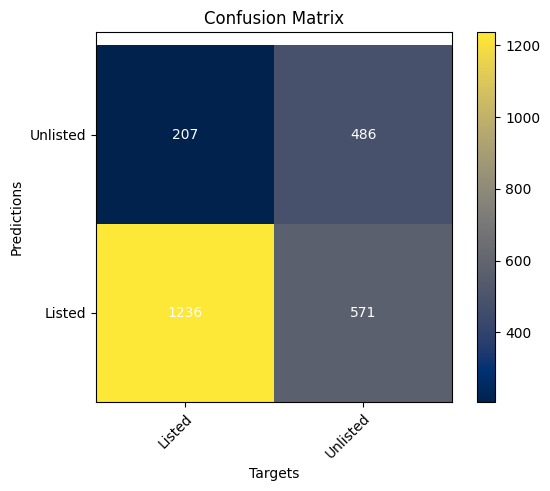

In [ ]:
plot_cm(confusion_matrix(y_val,knn_Tfidf_y_pred), labels.keys())

#### **4.2.3. KNN with MWE**

In [ ]:
knn_mwe = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
knn_mwe.fit(X_train_emb_flat,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [ ]:
knn_mwe_y_pred = knn_mwe.predict(X_val_emb_flat)

In [ ]:
print(classification_report(y_val, knn_mwe_y_pred,target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.88      0.85      0.86      1807
    Unlisted       0.63      0.69      0.66       693

    accuracy                           0.80      2500
   macro avg       0.76      0.77      0.76      2500
weighted avg       0.81      0.80      0.81      2500



<ipython-input-50-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


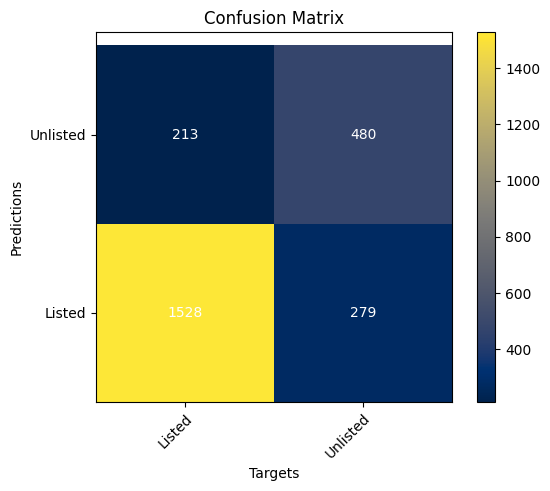

In [ ]:
plot_cm(confusion_matrix(y_val,knn_mwe_y_pred), labels.keys())

At this point, we've realized the models perform better with TF-IDF and MWE than with Bag of Words. From now on, we will stick to those approaches in order to vectorize our words.

### **4.3 Multi-Layer Percepton**

#### **4.3.1 Multi-Layer Perceptron with TF-IDF**

In [ ]:
mlp_Tfidf_standard=MLPClassifier()
mlp_Tfidf_standard.fit(X_train_Tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier()

In [ ]:
mlp_Tfidf_standard_y_pred = mlp_Tfidf_standard.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, mlp_Tfidf_standard_y_pred, target_names=labels.keys()))

              precision    recall  f1-score   support

      Listed       0.90      0.94      0.92      1807
    Unlisted       0.81      0.72      0.76       693

    accuracy                           0.87      2500
   macro avg       0.85      0.83      0.84      2500
weighted avg       0.87      0.87      0.87      2500



<ipython-input-34-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


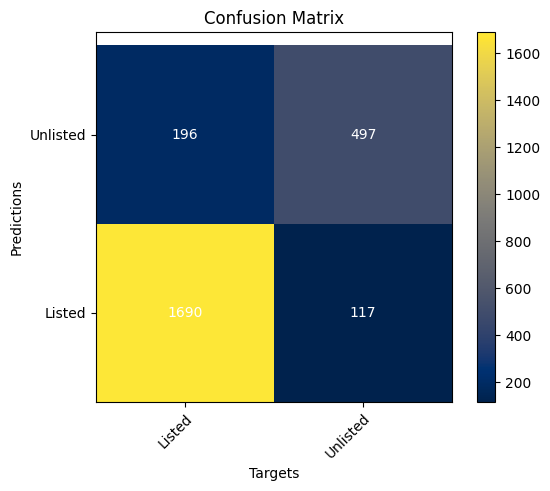

In [ ]:
plot_cm(confusion_matrix(y_val, mlp_Tfidf_standard_y_pred), labels.keys())

Let's now perform some Hyperparameter optimization:

In [ ]:
parameters_MLP = [
    {
        "hidden_layer_sizes": [(20, 30)],
        "activation": ["logistic", "relu"],
        "solver": ["adam", "sgd"],
        "alpha": [0.0001, 0.001],
    }
]

mlp_Tfidf = GridSearchCV(MLPClassifier(), parameters_MLP, cv=2, scoring='f1', n_jobs=-1)
mlp_Tfidf.fit(X_train_Tfidf, y_train)

print(mlp_Tfidf.best_params_)

In [ ]:
mlp_Tfidf_y_pred = mlp_Tfidf.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, mlp_Tfidf_y_pred, target_names=labels.keys()))

In [ ]:
plot_cm(confusion_matrix(y_val, mlp_Tfidf_y_pred), labels.keys())

#### **4.3.2 Multi-Layer Perceptron with MWE**

In [ ]:
mlp_emb_standard=MLPClassifier()
mlp_emb_standard.fit(X_train_emb_flat, y_train)

MLPClassifier()

In [ ]:
mlp_emb_standard_y_pred = mlp_emb_standard.predict(X_val_emb_flat)

In [ ]:
print(classification_report(y_val, mlp_emb_standard_y_pred, target_names=labels.keys()))

              precision    recall  f1-score   support

      Listed       0.92      0.93      0.92      1807
    Unlisted       0.81      0.79      0.80       693

    accuracy                           0.89      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.89      0.89      0.89      2500



<ipython-input-34-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


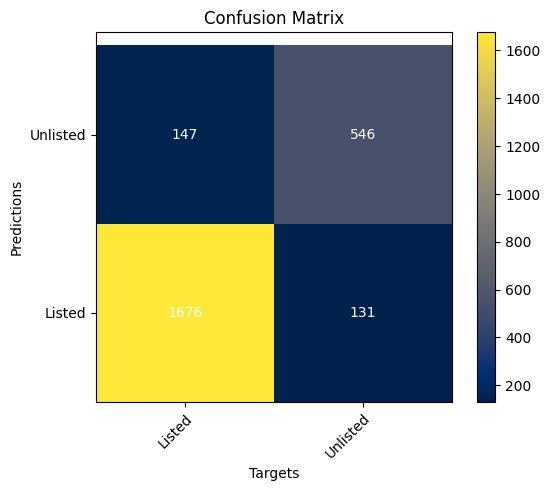

In [ ]:
plot_cm(confusion_matrix(y_val, mlp_emb_standard_y_pred), labels.keys())

### **4.4 Naive-Bayes Classifier**

#### **4.4.1 Naive-Bayer with TF-IDF**

In [ ]:
nb_Tfidf_standard= MultinomialNB()
nb_Tfidf_standard.fit(X_train_Tfidf, y_train)

In [ ]:
nb_Tfidf_standard_y_pred = nb_Tfidf_standard.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, nb_Tfidf_standard_y_pred,target_names = labels.keys()))

In [ ]:
plot_cm(confusion_matrix(y_val, nb_Tfidf_standard_y_pred), labels.keys())

Let's now perform some Hyperparameter optimization:

In [ ]:
parameters_NB = [
    {
        "alpha": [0.0001, 0.001, 0.01, 0.1],
        "fit_prior": [True, False],
        "class_prior": [None, [0.5, 0.5], [0.3, 0.7], [0.7, 0.3]]
    }
]

nb_Tfidf = GridSearchCV(MultinomialNB(), parameters_NB, cv=2, scoring='f1', n_jobs=-1)
nb_Tfidf.fit(X_train_Tfidf, y_train)

print(nb_Tfidf.best_params_)

{'alpha': 0.0001, 'class_prior': [0.7, 0.3], 'fit_prior': True}


In [ ]:
nb_Tfidf_y_pred = nb_Tfidf.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, nb_Tfidf_y_pred,target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.79      0.94      0.86      1807
    Unlisted       0.69      0.36      0.47       693

    accuracy                           0.78      2500
   macro avg       0.74      0.65      0.66      2500
weighted avg       0.76      0.78      0.75      2500



<ipython-input-36-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


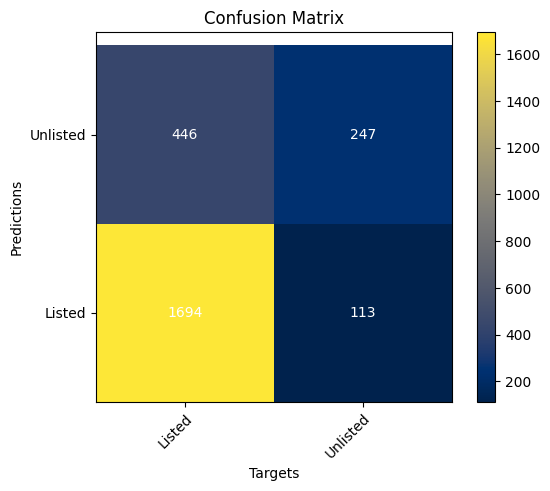

In [ ]:
plot_cm(confusion_matrix(y_val, nb_Tfidf_y_pred), labels.keys())

#### **4.4.2 Naive-Bayes with MWE**

In [ ]:
parameters_NB = [
    {
        "alpha": [0.0001, 0.001, 0.01, 0.1],
        "fit_prior": [True, False],
        "class_prior": [None, [0.5, 0.5], [0.3, 0.7], [0.7, 0.3]]
    }
]

X_train_shifted = X_train_emb_flat - np.min(X_train_emb_flat) + 1  # Add a constant to shift the values
X_train_log = np.log(X_train_shifted)

nb_mwe = GridSearchCV(MultinomialNB(), parameters_NB, cv=2, scoring='f1', n_jobs=-1)
nb_mwe.fit(X_train_log, y_train)

print(nb_mwe.best_params_)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


{'alpha': 0.0001, 'class_prior': [0.7, 0.3], 'fit_prior': True}


In [ ]:
nb_mwe_y_pred = nb_mwe.predict(X_val_emb_flat)

In [ ]:
labels = {"Listed":0, "Unlisted":1}
print(classification_report(y_val, nb_mwe_y_pred,target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.93      0.88      0.90      1807
    Unlisted       0.73      0.83      0.77       693

    accuracy                           0.87      2500
   macro avg       0.83      0.85      0.84      2500
weighted avg       0.87      0.87      0.87      2500



<ipython-input-89-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


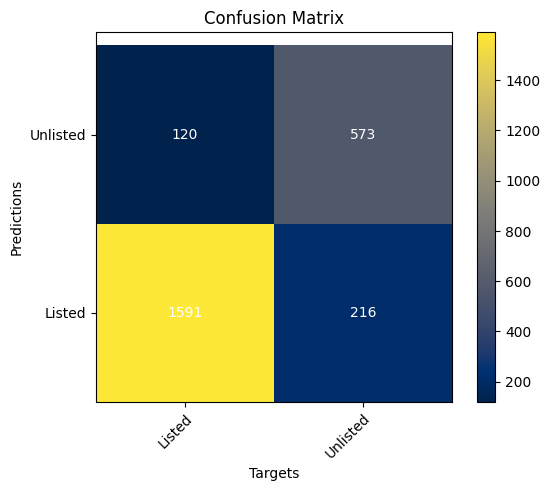

In [ ]:
plot_cm(confusion_matrix(y_val, nb_mwe_y_pred), labels.keys())

### **4.5 Support Vector Machines (SVM)**

#### **4.5.1 SVM with TF-IDF**

In [ ]:
svm_Tfidf_standard= SVC()
svm_Tfidf_standard.fit(X_train_Tfidf, y_train)

SVC()

In [ ]:
svm_Tfidf_standard_y_pred = svm_Tfidf_standard.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, svm_Tfidf_standard_y_pred,target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.81      0.96      0.87      1807
    Unlisted       0.78      0.40      0.53       693

    accuracy                           0.80      2500
   macro avg       0.79      0.68      0.70      2500
weighted avg       0.80      0.80      0.78      2500



<ipython-input-36-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


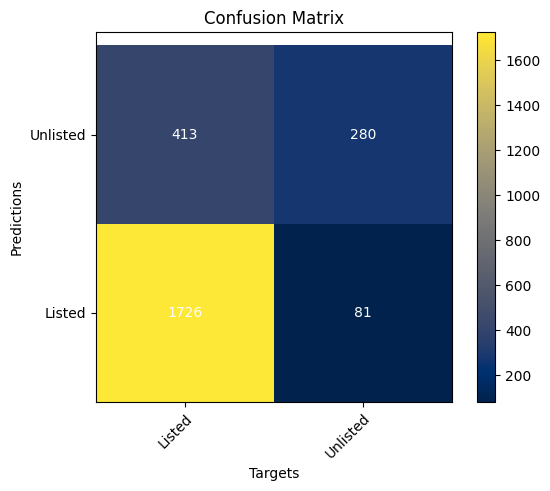

In [ ]:
plot_cm(confusion_matrix(y_val, svm_Tfidf_standard_y_pred), labels.keys())

Let's now perform some Hyperparameter optimization:

In [ ]:
parameters_SVM = [
    {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"]
    }
]

svm_Tfidf = GridSearchCV(SVC(), parameters_SVM, cv=2, scoring='f1', n_jobs=-1)
svm_Tfidf.fit(X_train_Tfidf, y_train)

print(svm_Tfidf.best_params_)

In [ ]:
svm_Tfidf_y_pred = svm_Tfidf.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, svm_Tfidf_y_pred,target_names = labels.keys()))

In [ ]:
plot_cm(confusion_matrix(y_val, svm_Tfidf_y_pred), labels.keys())

#### **4.5.2 SVM with MWE**

In [ ]:
parameters_SVM = [
    {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"]
    }
]

svm_mwe = GridSearchCV(SVC(), parameters_SVM, cv=2, scoring='f1', n_jobs=-1)
svm_mwe.fit(X_train_emb_flat, y_train)

print(svm_mwe.best_params_)

In [ ]:
svm_mwe_y_pred = svm_mwe.predict(X_val_emb_flat)

In [ ]:
print(classification_report(y_val, svm_mwe_y_pred,target_names = labels.keys()))

              precision    recall  f1-score   support

      Listed       0.85      0.93      0.88      1807
    Unlisted       0.75      0.56      0.64       693

    accuracy                           0.83      2500
   macro avg       0.80      0.74      0.76      2500
weighted avg       0.82      0.83      0.82      2500



<ipython-input-50-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


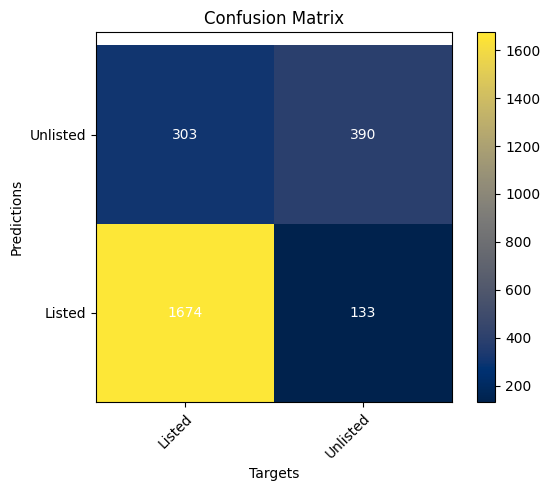

In [ ]:
plot_cm(confusion_matrix(y_val, svm_mwe_y_pred), labels.keys())

### **4.6 Gradient Boosting (GB)**

#### **4.6.1 GB with TF-IDF**

In [ ]:
gb_Tfidf_standard=GradientBoostingClassifier()
gb_Tfidf_standard.fit(X_train_Tfidf, y_train)


GradientBoostingClassifier()

In [ ]:
gb_Tfidf_standard_y_pred = gb_Tfidf_standard.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, gb_Tfidf_standard_y_pred, target_names=labels.keys()))

              precision    recall  f1-score   support

      Listed       0.84      0.85      0.85      1807
    Unlisted       0.60      0.58      0.59       693

    accuracy                           0.78      2500
   macro avg       0.72      0.71      0.72      2500
weighted avg       0.77      0.78      0.77      2500



<ipython-input-36-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


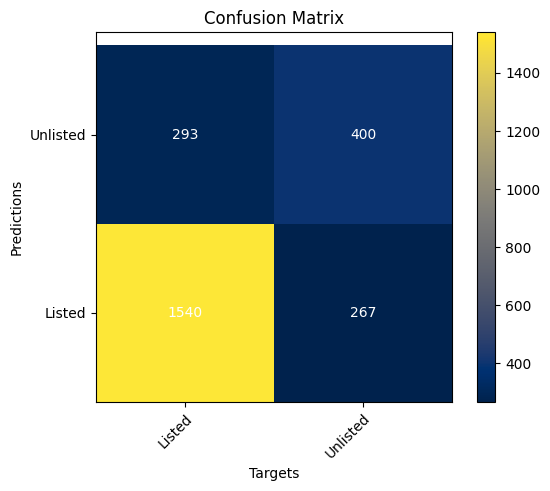

In [ ]:
plot_cm(confusion_matrix(y_val, gb_Tfidf_standard_y_pred), labels.keys())

Let's now perform some Hyperparameter optimization:

In [ ]:
parameters_GB = [
    {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.001],
        "max_depth": [3, 4]
    }
]

gb_Tfidf = GridSearchCV(GradientBoostingClassifier(), parameters_GB, cv=2, scoring='f1', n_jobs=-1)
gb_Tfidf.fit(X_train_Tfidf, y_train)

print(gb_Tfidf.best_params_)

In [ ]:
gb_Tfidf_y_pred = gb_Tfidf.predict(X_val_Tfidf)

In [ ]:
print(classification_report(y_val, gb_Tfidf_y_pred, target_names=labels.keys()))

In [ ]:
plot_cm(confusion_matrix(y_val, gb_Tfidf_y_pred), labels.keys())

#### **4.6.2 GB with MWE**

In [ ]:
gb_mwe_standard=GradientBoostingClassifier()
gb_mwe_standard.fit(X_train_emb_flat, y_train)

GradientBoostingClassifier()

In [ ]:
gb_mwe_y_pred = gb_mwe_standard.predict(X_val_emb_flat)

In [ ]:
labels = {"Listed":0, "Unlisted":1}
print(classification_report(y_val, gb_mwe_y_pred, target_names=labels.keys()))

              precision    recall  f1-score   support

      Listed       0.94      0.89      0.91      1807
    Unlisted       0.75      0.84      0.79       693

    accuracy                           0.88      2500
   macro avg       0.84      0.87      0.85      2500
weighted avg       0.89      0.88      0.88      2500



<ipython-input-36-3187e37d45a8>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


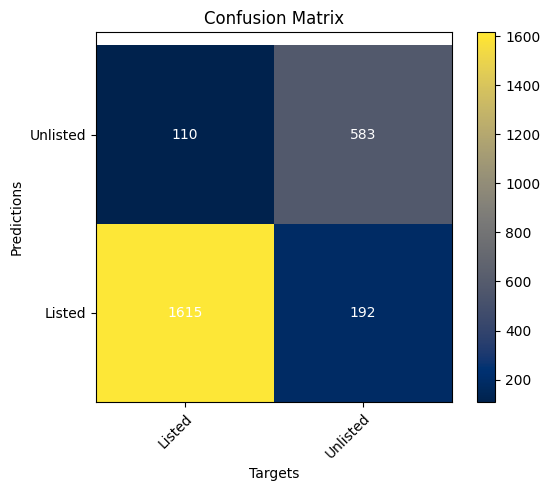

In [ ]:
plot_cm(confusion_matrix(y_val, gb_mwe_y_pred), labels.keys())

### **4.7 Long Short-Term Memory (LSTM)**



#### **4.7.1 LSTM 1**

This first achitecture consists of an input layer that takes input data with the shape (number of words per document, word embedding size). A mask layer is included to handle padding vectors and prevent them from being considered by the model. The masked input is then fed into a Bidirectional LSTM layer, which processes the input sequence in both forward and backward directions to capture contextual information effectively. The LSTM layer outputs its hidden state representations. These representations are then passed through a dense layer with a sigmoid activation function to produce the final output. The model is compiled with the Adam optimizer and binary cross-entropy loss function, suitable for binary classification tasks like the one we have at hand. The model's performance is evaluated using the f1 score as the evaluation metric. Overall, this architecture leverages Bidirectional LSTM to capture sequential information from the input data and make predictions based on it.

In [ ]:
train_len = []
for i in X_train_glove:
    train_len.append(len(i))
max(train_len)

In [ ]:
X_pad = pad_sequences(maxlen=162,sequences=X_train_glove, padding="post", dtype='float64')

In [ ]:
X = tf.convert_to_tensor(X_pad, dtype='float32')

In [ ]:
X.shape

In [ ]:
y = tf.one_hot(y_train, depth=2)

In [ ]:
'''model input in the shape(number of words per doc, word embedding size)'''
input_ = Input(shape=(162,100))

'''mask layer to avoid model from considering padding vectors'''
mask_layer = Masking(mask_value=0)
mask = mask_layer(input_)

'''BiLSTM layer'''

lstm = Bidirectional(LSTM(units=4))(mask)

'''activation layer'''
act = Dense(2, activation='sigmoid')(lstm)

'''model input and output'''
model = Model(input_, act)

'''model loss function and evaluation metrics'''
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["f1_score"])
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 162, 100)]        0         
                                                                 
 masking_23 (Masking)        (None, 162, 100)          0         
                                                                 
 bidirectional_23 (Bidirecti  (None, 8)                3360      
 onal)                                                           
                                                                 
 dense_32 (Dense)            (None, 2)                 18        
                                                                 
Total params: 3,378
Trainable params: 3,378
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X, y, batch_size=16, epochs=20, verbose=1, validation_split=0.20)

#### **4.7.2 LSTM 2**

This enhanced architecture incorporates more complexity and capacity by increasing the number of units, introducing attention mechanisms, and adding additional layers. These modifications aim to capture richer representations and improve the model's ability to learn intricate patterns in the text data.

In [ ]:
from keras.layers import Attention, Dropout

input_ = Input(shape=(162,100))

# Masking layer
mask_layer = Masking(mask_value=0)
mask = mask_layer(input_)

# BiLSTM layer
lstm = Bidirectional(LSTM(units=64))(mask)

# Dropout layer for regularization
dropout = Dropout(0.5)(lstm)

# Output layer with sigmoid activation for binary classification
output = Dense(2, activation='sigmoid')(dropout)

# Define the model
model2 = Model(input_, output)

# Compile the model with binary cross-entropy loss and F1 score as the evaluation metric
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['f1_score'])

# Print model summary
model2.summary()


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 162, 100)]        0         
                                                                 
 masking_24 (Masking)        (None, 162, 100)          0         
                                                                 
 bidirectional_24 (Bidirecti  (None, 128)              84480     
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 2)                 258       
                                                                 
Total params: 84,738
Trainable params: 84,738
Non-trainable params: 0
______________________________________________________

In [ ]:
history = model.fit(X, y, batch_size=16, epochs=20, verbose=1, validation_split=0.20)

Epoch 1/20
125/125 [==============================] - 2s 17ms/step - loss: 0.5984 - f1_score: 0.7137 - val_loss: 0.6486 - val_f1_score: 0.6685
Epoch 2/20
125/125 [==============================] - 2s 17ms/step - loss: 0.5950 - f1_score: 0.7140 - val_loss: 0.6487 - val_f1_score: 0.6685
Epoch 3/20
125/125 [==============================] - 3s 22ms/step - loss: 0.5921 - f1_score: 0.7140 - val_loss: 0.6479 - val_f1_score: 0.6685
Epoch 4/20
125/125 [==============================] - 3s 21ms/step - loss: 0.5893 - f1_score: 0.7140 - val_loss: 0.6502 - val_f1_score: 0.6685
Epoch 5/20
125/125 [==============================] - 2s 17ms/step - loss: 0.5877 - f1_score: 0.7140 - val_loss: 0.6483 - val_f1_score: 0.6685
Epoch 6/20
125/125 [==============================] - 2s 16ms/step - loss: 0.5838 - f1_score: 0.7140 - val_loss: 0.6495 - val_f1_score: 0.6685
Epoch 7/20
125/125 [==============================] - 2s 16ms/step - loss: 0.5804 - f1_score: 0.7140 - val_loss: 0.6514 - val_f1_score: 0.6683

## **5. Evaluation**

The evaluation of our models was mainly based on their respective confusion matrixes and individual metrics (accuracy, precision and recall), as well as the F1-Score that is presented after each of them.

In that sense, the model we will use to predict the labels on the unseen data is the Multi-Layer Perceptron with the multilingual word embeddings.

In [ ]:
best_model=mlp_emb_standard

## **6. Prediction on unseen data**

First, we need to replicate all the steps we made on the training corpus in the test one.

In [ ]:
airbnb_df_test['description'] = airbnb_df_test['description'].apply(remove_html_tags)
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].apply(remove_html_tags)
#test_reviews['comments'] = test_reviews['comments'].apply(remove_html_tags)

<ipython-input-7-8d51daeddf4f>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
for i, row in airbnb_df_test.iterrows():
    airbnb_df_test.at[i, 'description'] = re.sub(r'(?i)\b(?:License number|Alojamento Local Registro):?(?:</b><br />)?\s*(\S+)', '#LICENSENUMBER', row['description'])

In [ ]:
updates_description = clean(airbnb_df_test['description'], lemmatize = True, stemming = False)
updates_host = clean(airbnb_df_test['host_about'], lemmatize = True, stemming = False)
#updates_comments = clean(test_reviews['comments'], lemmatize = True, stemming = False)

100%|██████████| 1389/1389 [00:00<00:00, 4568.80it/s]


In [ ]:
update_df(airbnb_df_test, 'description', updates_description)
update_df(airbnb_df_test, 'host_about', updates_host)
#update_df(test_reviews, 'comments', updates_comments)

In [ ]:
test_reviews = pd.read_excel('/content/drive/My Drive/test_reviews_multilan.xlsx')
test_reviews = test_reviews[test_reviews['language'] == 'en']

In [ ]:
grouped_df_test = train_reviews.groupby('index')['comments'].agg(lambda x: ' '.join(x)).reset_index()

In [ ]:
# Perform a left join on 'airbnb_df_train' using the index column
merged_df_test = airbnb_df_test.merge(grouped_df_test, left_index=True, right_on='index', how='left')

In [ ]:
# Drop the redundant index column
merged_df_test.drop('index', axis=1, inplace=True)

In [ ]:
merged_df_test.reset_index(drop=True, inplace=True)
merged_df_test.index += 1

In [ ]:
# Replace NaN values in 'comments' column with an empty string
merged_df_test['comments'].fillna('', inplace=True)

In [ ]:
airbnb_df_test = merged_df_test
airbnb_df_test

In [ ]:
airbnb_df_test.to_excel('airbnb_df_test.xlsx', index=False)

In [ ]:
!cp airbnb_df_test.xlsx /content/drive/MyDrive

In [ ]:
airbnb_df_test = pd.read_excel('/content/drive/MyDrive/Faculdade Cursos Linkedin/Text MIning /airbnb_df_test.xlsx')

In [ ]:
airbnb_df_test['host_about'] = airbnb_df_test['host_about'].fillna('')
airbnb_df_test['comments'] = airbnb_df_test['comments'].fillna('')

In [ ]:
airbnb_df_test = airbnb_df_test.set_index(pd.Index(range(1, len(airbnb_df_test) + 1)))

We are almost ready to make the final predictions. We just need to apply the multilingual embeddings.

In [ ]:
X_test_emb = pd.DataFrame(columns=airbnb_df_test.columns)

In [ ]:
X_test_emb['description'] = airbnb_df_test['description'].apply(get_embeddings)
X_test_emb['host_about'] = airbnb_df_test['host_about'].apply(get_embeddings)
X_test_emb['comments'] = airbnb_df_test['comments'].apply(get_embeddings)

In [ ]:
X_test_emb_flat = np.array([np.concatenate(cell) for cell in X_test_emb.values])

Let's make the final predictions:

In [ ]:
final_predictions = best_model.predict(X_test_emb_flat)
final_predictions

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
answer = pd.DataFrame([airbnb_df_test.index.T, final_predictions]).T
answer.columns = ['index','unlisted']
answer

,index,unlisted
0,1,0
1,2,0
2,3,1
3,4,1
4,5,0
...,...,...
1384,1385,1
1385,1386,0
1386,1387,1
1387,1388,0


In [ ]:
answer["index"]=answer["index"].astype(int)
answer["unlisted"]=answer["unlisted"].astype(int)

In [ ]:
answer.to_csv('PredictionsMLP.csv', index = None)

In [ ]:
!cp PredictionsMLP.csv /content/drive/MyDrive

The end ☝